# Mixin: Music Annotation Exploratory Analysis

# Table of Contents
1. [Overview of Mixin Project](#Overview-of-Mixin-Project)
2. [Current Stage: Automated Chorus Identification](#Current-Stage:-Automated-Chorus-Identification)
3. [Exploratory Analysis](#Exploratory-Analysis)
    - [Data Profile](#Data-Profile)
    - [Label Validation](#Label-Validation)
    - [Audio Feature Generation & Visualization](#Audio-Feature-Generation-&-Visualization)
    - [Insights and Findings](#Insights-and-Findings)

---

# Overview of the Mixin Project
#### The Quest for an AI DJ

The year is 2024. Rapid developments in technology have revived a question that scholars have contemplated for eons: *Can I teach my computer how to DJ?*

The Mixin project aims to develop an autonomous DJ system that can select songs from an input playlist and arrange them into seamless, continuous mix—a feat traditionally reserved for carbon-based disc jockeys. 

#### Project Stages and Objectives
 **1) Automated Chorus Identification:** Accurately identify the parts of a song to play, skip, or use for transitions.
 
 **2) Algorithmic Song Selection:** Design an algorithm to assemble the optimal sequence of tracks that creates a smooth, natural flow based on features like keys, tempos, and energies.
 
 **3) Transition Engineering:** Leverage audio signal processing and music theory to design transitions that are audibly indistinguishable from those performed by a skilled human DJ.



# Current Stage: Automated Chorus Identification
The essence of DJing revolves around the art of storytelling through music. The narrative is sculpted not just by the selection of music, but by the mastery over which sections of a song are played or mixed. In this context, the ability to discern which musical segments to play, skip, or use for transitions is an essential skill for all DJs. Similarly, the ability to set, save, and recall cue points is an industry standard feature for DJ softwares. This process resembles the traditional vinyl DJ practice of setting cue points - physical stickers placed on records to mark significant moments. This practice requires a deep familiarity with each track and strategic foresight into how each segment could be woven into the broader narrative of the set. For an AI DJ system, the challenge is to embed this nuanced understanding of musical structure and emotional progression into algorithms capable of analyzing audio features. The current stage aims to develop an automated method to locate the beginning and end of core thematic segments (i.e. choruses) in a song.



# Exploratory Analysis
The exploratory data analysis in this stage will consist of:
- Data Profiling
- Label Validation & Hypothesis Testing
- Audio Feature Generation & Visualization

## Data Profile

---

### Load the Dataset

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa

# Enable inline plotting in Jupyter notebooks
%matplotlib inline

# Setting custom dimensions for Pandas display
pd.set_option('display.max_columns', None)  # This shows all columns
pd.set_option('display.max_colwidth', 15) 

# Load the dataset
df = pd.read_csv('../data/dataframes/clean_labeled.csv', dtype={'SongID': object})

# Display the first few rows of the dataframe
df.head()

SongID  start_time    end_time  start_frame  end_frame   label    TrackName  \
0      1         0.0   61.000000            0       5718   other  Bass Inside   
1      1        61.0  121.900000         5718      11428  chorus  Bass Inside   
2      1       121.9  167.700000        11428      15721   other  Bass Inside   
3      1       167.7  228.600000        15721      21431  chorus  Bass Inside   
4      1       228.6  259.995011        21431      24374   other  Bass Inside   

     Artists       Genre        FilePath  sp_danceability  sp_energy  sp_key  \
0  AC Slater  Bass House  ..\data\aud...           0.905       0.838     6.0   
1  AC Slater  Bass House  ..\data\aud...           0.905       0.838     6.0   
2  AC Slater  Bass House  ..\data\aud...           0.905       0.838     6.0   
3  AC Slater  Bass House  ..\data\aud...           0.905       0.838     6.0   
4  AC Slater  Bass House  ..\data\aud...           0.905       0.838     6.0   

   sp_loudness  sp_speechiness  sp_acousticness  sp_instrumentalness  \
0       -6.838          0.0499         0.00112            0.839        
1       -6.838          0.0499         0.00112            0.839        
2       -6.838          0.0499         0.00112            0.839        
3       -6.838          0.0499         0.00112            0.839        
4       -6.838          0.0499         0.00112            0.839        

   sp_liveness  sp_valence  sp_tempo  sp_time_signature        sp_genre  \
0        0.608       0.464   126.007             4.0     electro hou...   
1        0.608       0.464   126.007             4.0     electro hou...   
2        0.608       0.464   126.007             4.0     electro hou...   
3        0.608       0.464   126.007             4.0     electro hou...   
4        0.608       0.464   126.007             4.0     electro hou...   

   sampling_rate  
0          48000  
1          48000  
2          48000  
3          48000  
4          48000

### Dataset Overview

---

In [214]:
def get_summary(df):
    """Generates a summary dataframe with descriptive statistics and example values."""
    # Add example value for all columns (numeric and non-numeric)
    example_value = df.apply(lambda x: np.random.choice(x.dropna().values) 
                             if not x.dropna().empty else np.nan)
    
    # Construct the initial summary dataframe with general info
    summary_df = pd.DataFrame({
        'Non-NA Count': df.notna().sum(),
        'NA Count': df.isna().sum(),
        'Unique Values': df.nunique(dropna=False),
        'Data Type': df.dtypes,
        'Example Value': example_value
    })
    
    # Compute descriptive statistics for numeric columns and merge with summary_df
    summary_df = summary_df.join(df.describe().T.rename(columns={
        'mean': 'Mean', 'std': 'Std', 'min': 'Min',
        '25%': '25th Percentile', '50%': 'Median',
        '75%': '75th Percentile', 'max': 'Max'
    }), how='left')
    
    return summary_df

get_summary(df)

Non-NA Count  NA Count  Unique Values Data Type  \
SongID                   1815         0            332    object   
start_time               1815         0            884   float64   
end_time                 1815         0           1202   float64   
start_frame              1815         0            884     int64   
end_frame                1815         0           1188     int64   
label                    1815         0              2    object   
TrackName                1815         0            331    object   
Artists                  1815         0            275    object   
Genre                    1608       207             62    object   
FilePath                 1815         0            332    object   
sp_danceability          1751        64            206   float64   
sp_energy                1751        64            217   float64   
sp_key                   1751        64             13   float64   
sp_loudness              1751        64            312   float64   
sp_speechiness           1751        64            259   float64   
sp_acousticness          1751        64            296   float64   
sp_instrumen...          1751        64            281   float64   
sp_liveness              1751        64            252   float64   
sp_valence               1751        64            260   float64   
sp_tempo                 1751        64            263   float64   
sp_time_sign...          1751        64              5   float64   
sp_genre                 1619       196            185    object   
sampling_rate            1815         0              1     int64   

                  Example Value   count          Mean          Std  \
SongID                      258     NaN           NaN          NaN   
start_time                170.3  1815.0     94.596088    69.411400   
end_time                  157.6  1815.0    131.444524    65.181639   
start_frame                7200  1815.0   8868.025895  6507.211159   
end_frame                 15035  1815.0  12322.476584  6110.769424   
label                     other     NaN           NaN          NaN   
TrackName        Marianela (...     NaN           NaN          NaN   
Artists             Eden Prince     NaN           NaN          NaN   
Genre              German House     NaN           NaN          NaN   
FilePath         ..\data\aud...     NaN           NaN          NaN   
sp_danceability           0.719  1751.0      0.748905     0.110226   
sp_energy                 0.858  1751.0      0.825734     0.137458   
sp_key                      0.0  1751.0      5.708738     3.832601   
sp_loudness              -7.505  1751.0     -5.827974     1.867070   
sp_speechiness           0.0706  1751.0      0.092512     0.074880   
sp_acousticness          0.0276  1751.0      0.051555     0.105352   
sp_instrumen...        0.000001  1751.0      0.396134     0.332203   
sp_liveness              0.0617  1751.0      0.178786     0.152701   
sp_valence                0.781  1751.0      0.475477     0.226362   
sp_tempo                159.972  1751.0    126.174923    12.993880   
sp_time_sign...             4.0  1751.0      3.974300     0.280656   
sp_genre         electro hou...     NaN           NaN          NaN   
sampling_rate             48000  1815.0  48000.000000     0.000000   

                          Min  25th Percentile      Median  75th Percentile  \
SongID                    NaN             NaN          NaN             NaN    
start_time           0.000000        34.85000      92.1000      150.000000    
end_time             0.200000        76.40000     133.9000      180.168526    
start_frame          0.000000      3266.50000    8634.0000    14062.000000    
end_frame           18.000000      7162.00000   12553.0000    16890.500000    
label                     NaN             NaN          NaN             NaN    
TrackName                 NaN             NaN          NaN             NaN    
Artists                   NaN             NaN          NaN             

### Distribution of Labels

---

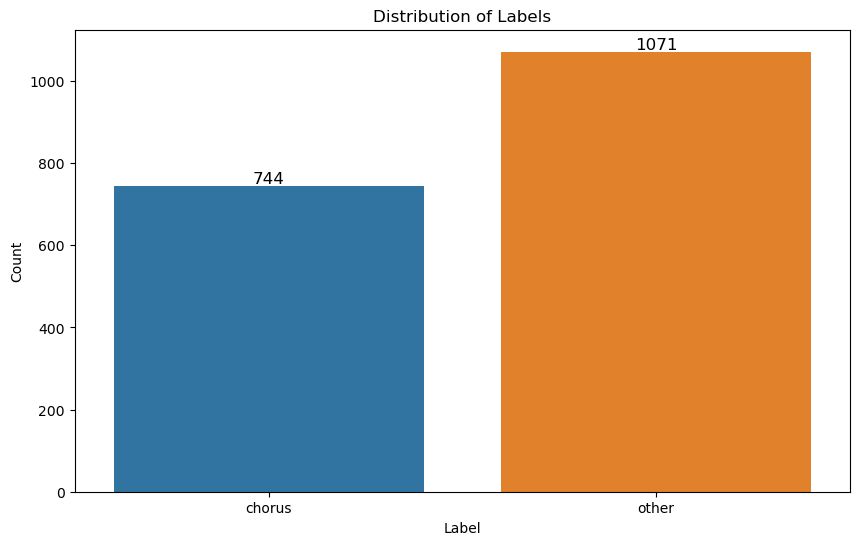

In [215]:
# Plotting the distribution of labels with annotated counts
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='label', data=df, order=['chorus', 'other'])
ax.set_title('Distribution of Labels')
ax.set_xlabel('Label')
ax.set_ylabel('Count')

# Annotating bars with label counts
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

### Number of Labeled Chorus Segments per Song

---

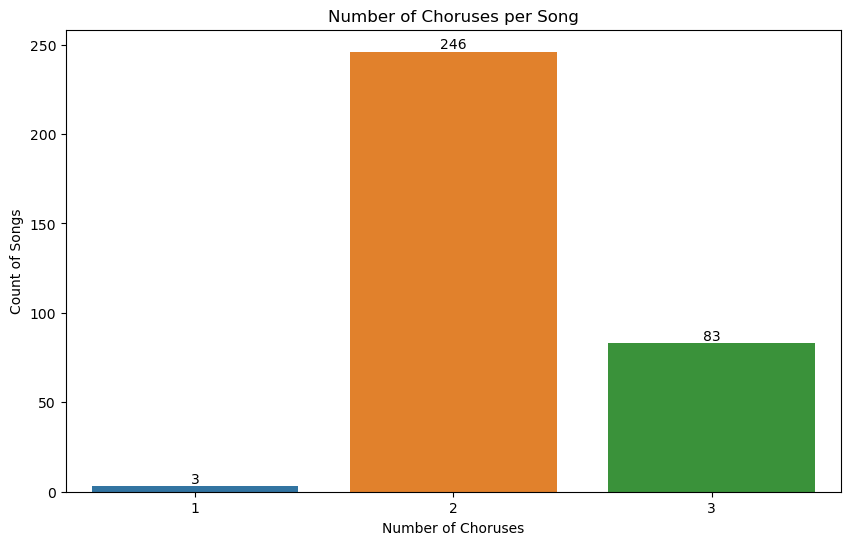

In [216]:
# Plotting the number of choruses per song with annotated counts
choruses_per_song = df[df['label'] == 'chorus'].groupby('SongID').size()
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=choruses_per_song)
ax.set_title('Number of Choruses per Song')
ax.set_xlabel('Number of Choruses')
ax.set_ylabel('Count of Songs')

# Annotating bars with count of songs
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

### Distribution of Chorus Lengths

---

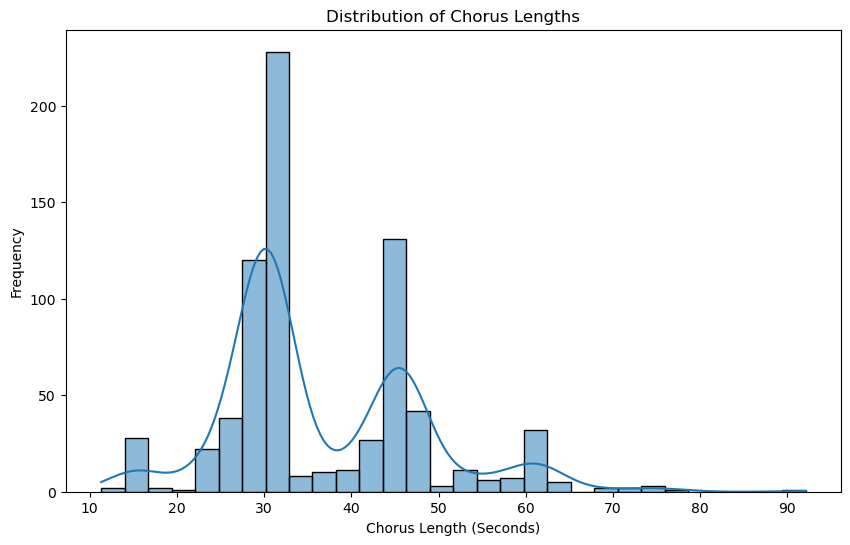

In [217]:
# Plotting the distribution of chorus lengths
df['chorus_length'] = np.where(df['label'] == 'chorus', df['end_time'] - df['start_time'], 0)
plt.figure(figsize=(10, 6))
ax = sns.histplot(df.loc[df['chorus_length'] > 0, 'chorus_length'], bins=30, kde=True)
ax.set_title('Distribution of Chorus Lengths')
ax.set_xlabel('Chorus Length (Seconds)')
ax.set_ylabel('Frequency')
plt.show()

### Distribution of Chorus Positions within Tracks

---


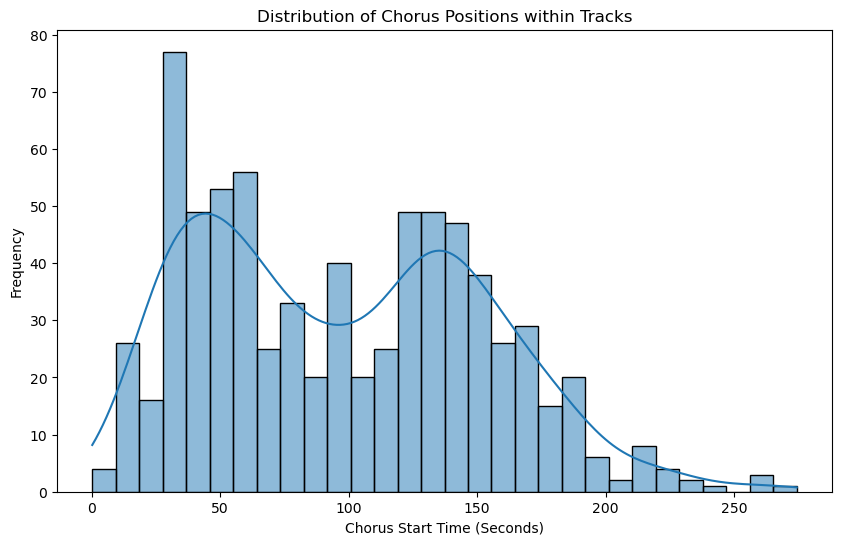

In [218]:
# Plotting the distribution of chorus start times within tracks
plt.figure(figsize=(10, 6))
ax = sns.histplot(df.loc[df['label'] == 'chorus', 'start_time'], bins=30, kde=True)
ax.set_title('Distribution of Chorus Positions within Tracks')
ax.set_xlabel('Chorus Start Time (Seconds)')
ax.set_ylabel('Frequency')
plt.show()

### Song-level Analyses using Spotify Features 

---

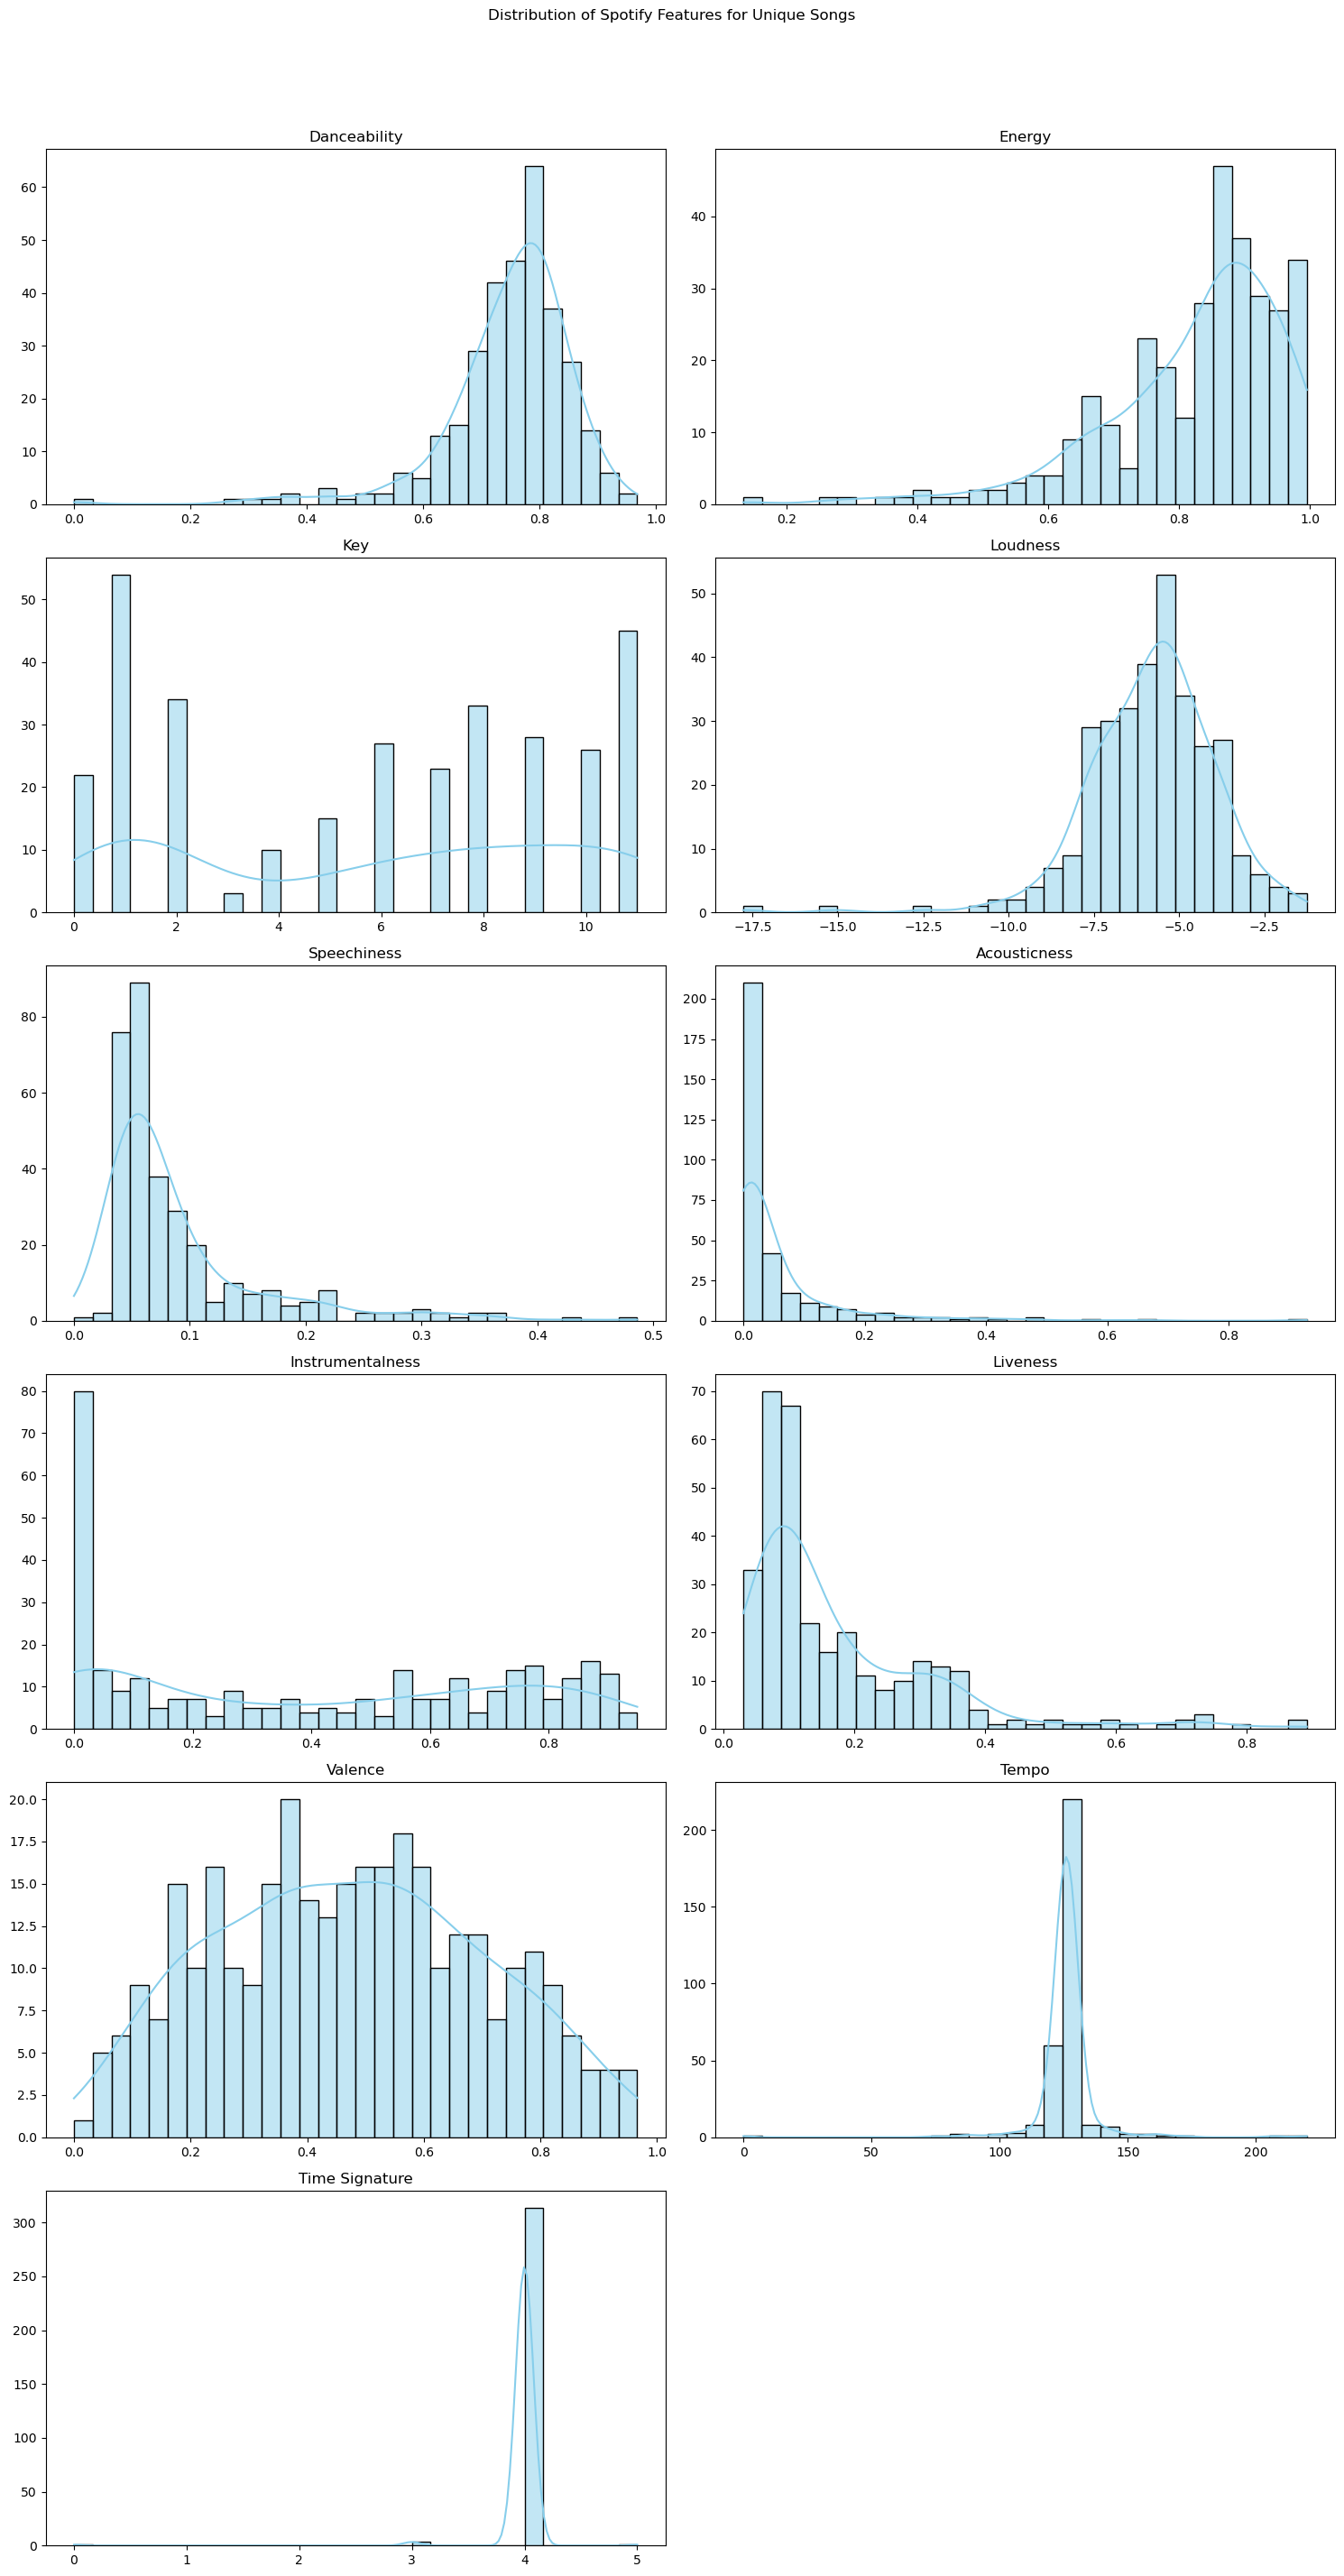

In [524]:
song_level_df = df.copy()
song_level_df = song_level_df.drop_duplicates(subset=['SongID'])
spotify_features = [col for col in song_level_df.columns if col.startswith('sp_') and col != 'sp_genre']
# Calculate the number of rows needed for subplots
nrows = (len(spotify_features) + 1) // 2
ncols = 2

# Create a figure with subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
fig.suptitle("Distribution of Spotify Features for Unique Songs")

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through the features and create histograms
for i, feature in enumerate(spotify_features):
    sns.histplot(song_level_df[feature], ax=axes[i], bins=30, kde=True, color='skyblue', edgecolor='black')
    axes[i].set_title(feature.replace('sp_', '').replace('_', ' ').title())
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Hide any unused subplots
for j in range(i + 1, nrows * ncols):
    axes[j].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
plt.show()

### Genre-level Exploratory Analysis

---

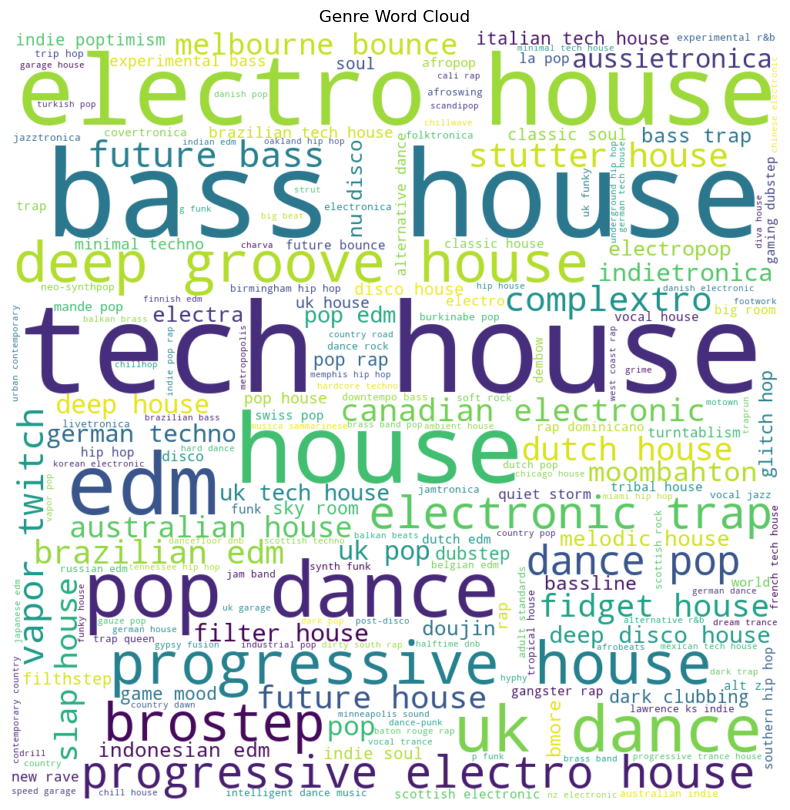

In [528]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Prepare the data for the word cloud and the bar chart
df_genres = df.copy()
df_genres['sp_genre'] = df_genres['sp_genre'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
all_genres = [genre for sublist in df_genres['sp_genre'] for genre in sublist]
genre_counts = pd.Series(all_genres).value_counts()
popular_genres = genre_counts[genre_counts >= 5]

# Create a word cloud of popular genres
wordcloud = WordCloud(width=1000, height=1000, background_color='white').generate_from_frequencies(popular_genres)

# Count unique artists associated with each genre
genre_artist_counts = {genre: df_genres[df_genres['sp_genre'].apply(lambda x: genre in x)]['Artists'].str.split('/').explode().nunique() 
                       for genre in genre_counts.index}
sorted_genre_artist_counts = dict(sorted(genre_artist_counts.items(), key=lambda item: item[1], reverse=True)[:50])

# Plot the word cloud 
plt.figure(figsize=(12, 10)) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Genre Word Cloud')
plt.show()

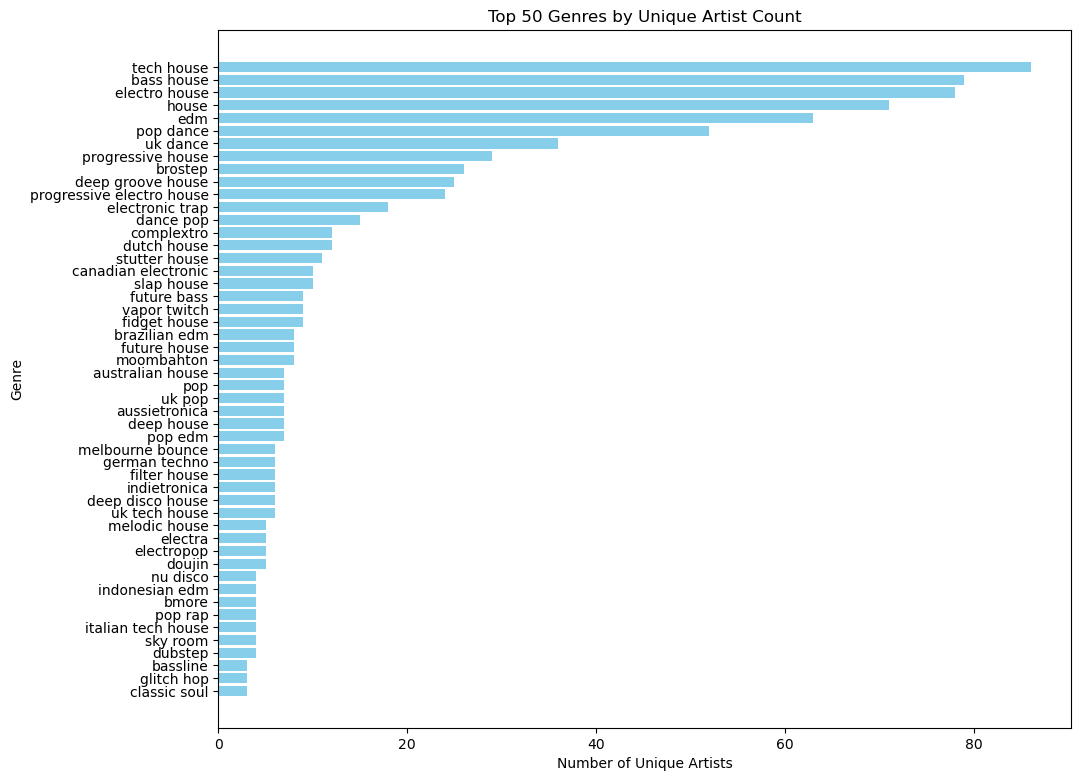

In [533]:
# Create a new figure for the bar chart
plt.figure(figsize=(12, 9))  # Adjust the size as needed
plt.barh(list(sorted_genre_artist_counts.keys()), list(sorted_genre_artist_counts.values()), color='skyblue')
plt.xlabel('Number of Unique Artists')
plt.ylabel('Genre')
plt.title('Top 50 Genres by Unique Artist Count')
plt.gca().invert_yaxis()  # Invert the y-axis to have the largest values on top
plt.tight_layout(pad=5)
plt.show()

### Genre Association Network

---

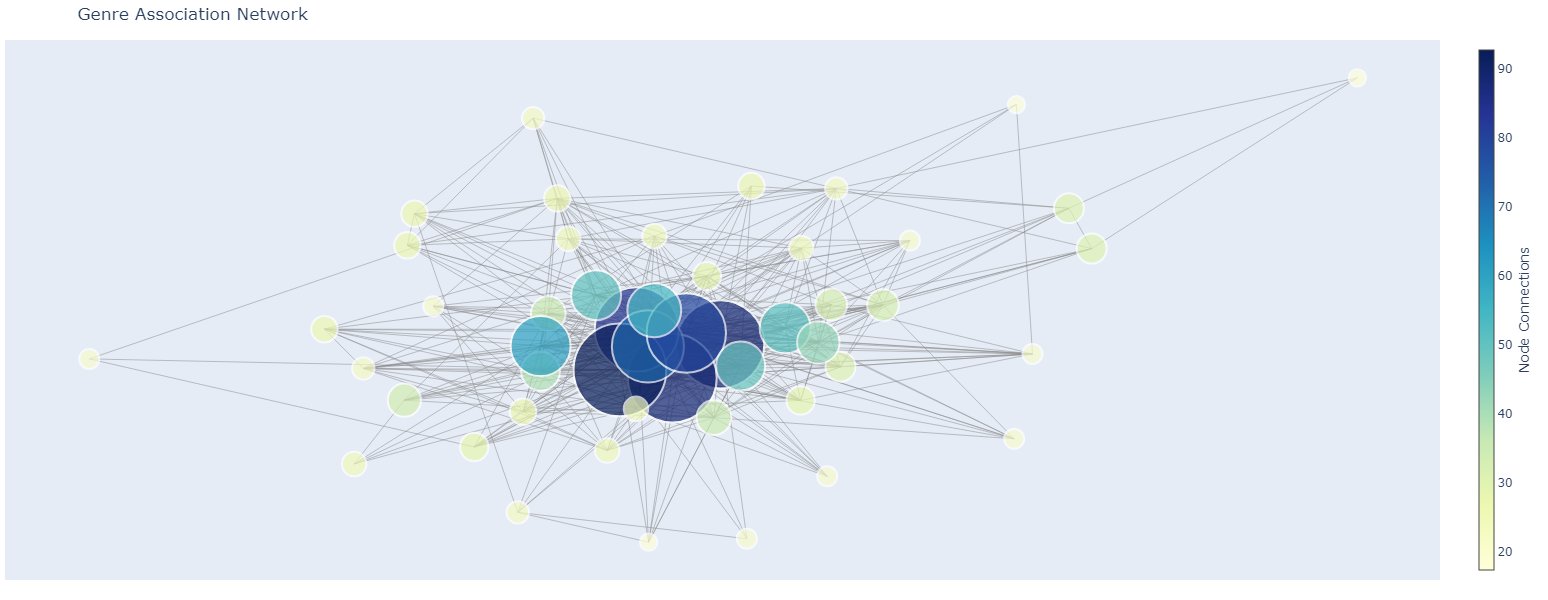

In [221]:
import networkx as nx
import math
import plotly.graph_objs as go

# Initialize graph and get top genres
G = nx.Graph()
top_genres = list(sorted_genre_artist_counts.keys())[:50]  

# Build genre-artist associations
genre_artist_counts = {}
for genres, artists in df_genres[df_genres['sp_genre'].apply(lambda x: any(g in x for g in top_genres))][['sp_genre', 'Artists']].values:
    artists_set = set(artists.split('/'))
    for genre in genres:
        if genre in top_genres:
            genre_artist_counts.setdefault(genre, set()).update(artists_set)

# Add nodes based on genre artist counts
for genre, artists in genre_artist_counts.items():
    G.add_node(genre, size=len(artists))

# Add edges between genres sharing artists
for genres in df_genres['sp_genre']:
    for genre1 in genres:
        for genre2 in genres:
            if genre1 in top_genres and genre2 in top_genres and genre1 != genre2:
                weight = 1 + G[genre1][genre2]['weight'] if G.has_edge(genre1, genre2) else 1
                G.add_edge(genre1, genre2, weight=weight)

# Layout calculation and edge/node extraction
pos = nx.spring_layout(G, k=0.3, iterations=50)
edge_x, edge_y = [], []
for edge in G.edges():
    x0, y0, x1, y1 = *pos[edge[0]], *pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

node_x, node_y = zip(*[pos[node] for node in G.nodes()])
node_sizes = [10 * math.sqrt(G.nodes[node]['size']) for node in G.nodes()]

# Plot configuration
edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888'), mode='lines', hoverinfo='none')
node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text', marker=dict(
    showscale=True, colorscale='YlGnBu', size=node_sizes, color=node_sizes, line_width=2,
    colorbar=dict(thickness=15, title='Node Connections', xanchor='left', titleside='right')))

node_trace.text = [f'{node}: {G.nodes[node]["size"]} artists' for node in G.nodes()]

fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(
    title='Genre Association Network', showlegend=False, hovermode='closest',
    margin=dict(b=20, l=5, r=5, t=40), xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False), width=800, height=600))

fig.show()


### Spotify Audio Features Averaged by Genre

---

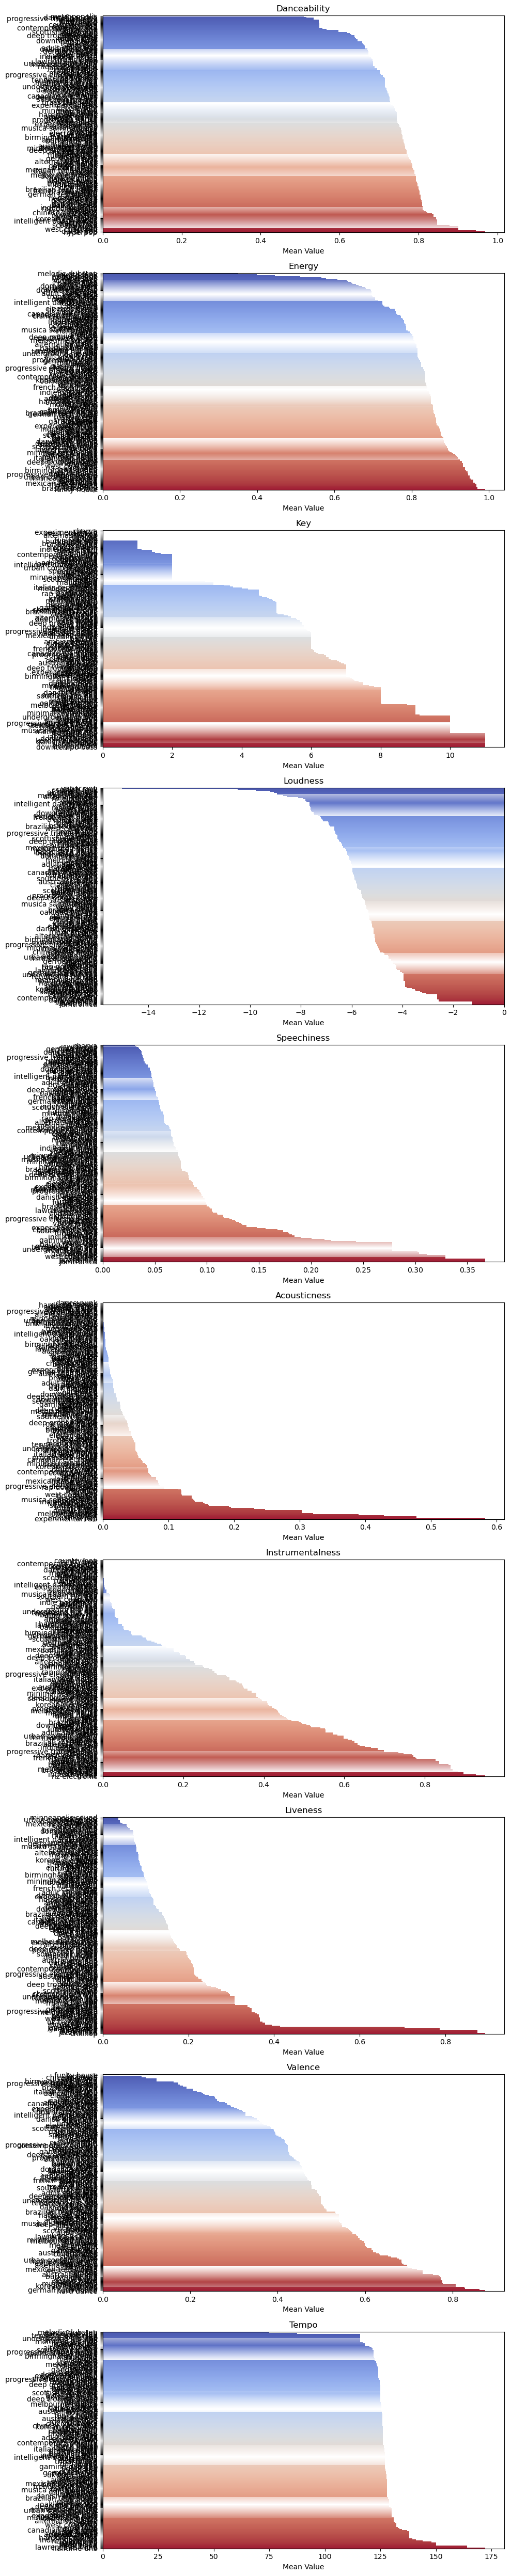

In [535]:
# Exploding the 'sp_genre' column
df_exploded = df.assign(sp_genre=df['sp_genre'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])).explode('sp_genre')

# Calculate mean of features by genre
features = [
    'sp_danceability', 'sp_energy', 'sp_key', 'sp_loudness', 
    'sp_speechiness', 'sp_acousticness', 'sp_instrumentalness', 
    'sp_liveness', 'sp_valence', 'sp_tempo'
]
genre_features = df_exploded.groupby('sp_genre')[features].mean().reset_index()

# Determine the number of rows for subplots
nrows = len(features)

# Create a large figure to accommodate all subplots
plt.figure(figsize=(10, 5 * nrows))

# Loop through the features and create a subplot for each
for i, feature in enumerate(features):
    plt.subplot(nrows, 1, i + 1)
    sorted_data = genre_features.sort_values(by=feature, ascending=True)
    sns.barplot(x=feature, y='sp_genre', data=sorted_data, palette='coolwarm')
    plt.title(feature.split('_')[1].capitalize())
    plt.xlabel('Mean Value')
    plt.ylabel('')

plt.tight_layout()
plt.show()

## Label Validation

---

In this section, we aim to evaluate the quality of manually labeled chorus segments, tempo estimation methods, and beat-grid generation algorithms.

It's important to note that this evaluation is conducted in the absence of an external ground truth for direct comparison. Instead, we are banking on the hypothesis that a strong alignment between the chorus labels and an independently generated beat-grid and tempo estimation signifies proximity to what would be considered the "true" structure of the song. This alignment-based approach to validation assumes that both the manual labeling process and the algorithmic estimations accurately capture the essential features of the music, thereby enabling the autonomous DJ system to perform seamlessly. To this end, we will also A/B test various parameter estimation methods to see which one yields the best alignment with chorus labels.

### Methodology

1. **Manual Labeling of Choruses:** Choruses were manually labeled such that the start aligns with the first downbeat of the initial bar, while the end follows the last downbeat of the final bar. Refer to the [Mixin Data Annotation Guide](https://docs.google.com/document/d/1NorWU7DheD0gmgCQtoegtga73mRPj3a_B4EIB_Ppnvc/edit?usp=sharing) for the full criteria and methodology. The chorus endpoints can be used to derive a beat grid, whose quality we can assess through its proximity to chorus start/end markers. Close alignment between labels and bar grid indices would suggest consistent labeling per the operational definiition. 
2. **Tempo Estimation**: Tempo is an important parameter that should be estimated as accurately as possible, as it will be used to to generate a beat and bar grid, which can then be used to partition songs into meaningful units for modeling and mixing. 
3. **Assumptions & Hypothesis**: 
- To examine whether our labels are consistent with our operational definition, we hypothesize that the chorus start and end timestamps are located on or within an acceptable distance from an index in the bar grid. In other words, a chorus should be fully encapsulated in between two bar indices.  
- We also use this opportunity to test various tempo estimation methods and grid generating algorithms under the assumption that tempos and grids closer to ground truth will result in a closer alignment between labels and bar indices. 

### Load Data

In [237]:
import numpy as np
import pandas as pd
import librosa
from tqdm.auto import tqdm
from math import floor, sqrt
from scipy.stats import pearsonr
from scipy.signal import correlate

# Load the dataset
file_path = '../data/dataframes/clean_labeled.csv'  
df = pd.read_csv(file_path)

df.head()

SongID  start_time    end_time  start_frame  end_frame   label  \
0       1         0.0   61.000000            0       5718   other   
1       1        61.0  121.900000         5718      11428  chorus   
2       1       121.9  167.700000        11428      15721   other   
3       1       167.7  228.600000        15721      21431  chorus   
4       1       228.6  259.995011        21431      24374   other   

     TrackName    Artists       Genre        FilePath  sp_danceability  \
0  Bass Inside  AC Slater  Bass House  ..\data\aud...           0.905    
1  Bass Inside  AC Slater  Bass House  ..\data\aud...           0.905    
2  Bass Inside  AC Slater  Bass House  ..\data\aud...           0.905    
3  Bass Inside  AC Slater  Bass House  ..\data\aud...           0.905    
4  Bass Inside  AC Slater  Bass House  ..\data\aud...           0.905    

   sp_energy  sp_key  sp_loudness  sp_speechiness  sp_acousticness  \
0      0.838     6.0       -6.838          0.0499         0.00112    
1      0.838     6.0       -6.838          0.0499         0.00112    
2      0.838     6.0       -6.838          0.0499         0.00112    
3      0.838     6.0       -6.838          0.0499         0.00112    
4      0.838     6.0       -6.838          0.0499         0.00112    

   sp_instrumentalness  sp_liveness  sp_valence  sp_tempo  sp_time_signature  \
0           0.839             0.608       0.464   126.007             4.0      
1           0.839             0.608       0.464   126.007             4.0      
2           0.839             0.608       0.464   126.007             4.0      
3           0.839             0.608       0.464   126.007             4.0      
4           0.839             0.608       0.464   126.007             4.0      

         sp_genre  sampling_rate  
0  electro hou...          48000  
1  electro hou...          48000  
2  electro hou...          48000  
3  electro hou...          48000  
4  electro hou...          48000

---

### Functions

In [430]:
def beat_tracking_dp(y, sr, onset_env=None,hop_length=512, alpha=0.5):
    """Perform beat tracking using dynamic programming."""
    tempo_estimate, _ = librosa.beat.beat_track(y=y, sr=sr)
    floor_tempo = floor(tempo_estimate)
    tempo_hypotheses = [floor_tempo - 1, floor_tempo, tempo_estimate, floor_tempo + 1]
    tempo_hypotheses = np.unique(tempo_hypotheses)

    if onset_env is None:
        onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    time_step = hop_length / sr
    time_grid = np.arange(len(onset_env)) * time_step
    C = np.zeros((len(onset_env), len(tempo_hypotheses)))
    P = np.zeros_like(C, dtype=int)

    for i, t in enumerate(time_grid[1:], 1):
        for k, tempo in enumerate(tempo_hypotheses):
            tau_p = 60 / tempo
            start = max(0, i - int(2 * tau_p / time_step))
            end = max(0, i - int(tau_p / (2 * time_step)))
            if start < end:
                transition_scores = C[start:end, k] - alpha * (np.log((t - time_grid[start:end]) / tau_p))**2
                best_predecessor = start + np.argmax(transition_scores)
                max_score = transition_scores[best_predecessor - start]
            else:
                best_predecessor = 0
                max_score = 0
            C[i, k] = onset_env[i] + max_score
            P[i, k] = best_predecessor

    best_tempo_index = np.argmax(C[-1])
    best_bpm = tempo_hypotheses[best_tempo_index]

    # Backtrace to recover the beat sequence
    beat_frames = [len(onset_env) - 1]  # Start from the last frame
    current_frame = beat_frames[-1]

    while current_frame > 0:
        current_frame = P[current_frame, best_tempo_index]
        beat_frames.append(current_frame)

    beat_frames.pop()  # Remove the last appended frame which is zero due to initialization
    beat_frames.reverse()  # Reverse the beat frames to be in chronological order

    return best_bpm, beat_frames

def adjust_tempo_values(*tempo_values):
    """Adjusts tempo values based on specified logic."""
    adjusted_tempos = []
    for tempo in tempo_values:
        if tempo > 140:
            adjusted_tempos.append(tempo / 2)
        elif tempo < 70:
            adjusted_tempos.append(tempo * 2)
        else:
            adjusted_tempos.append(tempo)
    return adjusted_tempos

def generate_beats_and_bars(first_beat_time, tempo, time_signature_num, duration):
    """Generate beat and measure grids within the duration of a song."""
    seconds_per_beat = 60.0 / tempo
    beats_per_measure = time_signature_num
    seconds_per_measure = seconds_per_beat * beats_per_measure

    # Generate beat grid forward
    beat_grid_forward = [first_beat_time + i * seconds_per_beat for i in range(int((duration - first_beat_time) / seconds_per_beat))]
    
    # Generate beat grid backward
    beat_grid_backward = [first_beat_time - i * seconds_per_beat for i in range(1, int(first_beat_time / seconds_per_beat) + 1)]
    beat_grid_backward.reverse()

    # Combine beat grids
    beat_grid = beat_grid_backward + beat_grid_forward

    # Generate measure grid forward
    measure_grid_forward = [first_beat_time + i * seconds_per_measure for i in range(int((duration - first_beat_time) / seconds_per_measure))]
    
    # Generate measure grid backward
    measure_grid_backward = [first_beat_time - i * seconds_per_measure for i in range(1, int(first_beat_time / seconds_per_measure) + 1)]
    measure_grid_backward.reverse()

    # Combine measure grids
    measure_grid = measure_grid_backward + measure_grid_forward

    return beat_grid, measure_grid

def optimize_measure_grid(measure_grid, beat_grid, tempo, duration):
    """Optimizes the measure grid to better align with the beat grid within constraints."""
    max_adjustment = (60 / (3 * tempo))
    
    if len(measure_grid) < 2:
        return measure_grid

    original_seconds_per_measure = measure_grid[1] - measure_grid[0]
    optimized_measure_grid = measure_grid[:]

    for i in range(len(optimized_measure_grid) - 1):
        best_adjustment = 0
        min_distance_sum = float('inf')

        for adjustment in np.linspace(-max_adjustment, max_adjustment, 100):
            predicted_end = optimized_measure_grid[i] + adjustment + original_seconds_per_measure * (len(optimized_measure_grid) - i - 1)
            if predicted_end > duration:
                continue

            distance_sum = sum(min(abs(beat_time - (optimized_measure_grid[i] + adjustment + k * original_seconds_per_measure)) for k in range(len(optimized_measure_grid) - i)) for beat_time in beat_grid)

            if distance_sum < min_distance_sum:
                min_distance_sum = distance_sum
                best_adjustment = adjustment

        for j in range(i, len(optimized_measure_grid)):
            optimized_measure_grid[j] += best_adjustment
            if optimized_measure_grid[j] > duration:
                optimized_measure_grid = optimized_measure_grid[:j + 1]
                break

    return optimized_measure_grid


---

### Preprocessing Loop to Generate Beat and Bar Grids

In [431]:
from tqdm.auto import tqdm
import pandas as pd
import librosa

# Initialize results list
results = []

# Loop through each unique SongID in the DataFrame
for song_id in tqdm(df['SongID'].unique(), desc="Processing..."):
    data = df.loc[df['SongID'] == song_id]
    audio_path = f'../data/audio_files/processed/{song_id}.mp3'
    y, sr = librosa.load(audio_path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    
    # Beat tracking with custom function
    tempo, beats = beat_tracking_dp(y, sr=sr, onset_env=onset_env, hop_length=512)
    
    # Librosa's beat tracking
    lib_tempo, lib_beats = librosa.beat.beat_track(y=y, sr=sr, hop_length=512)
    
    # Spotify's tempo, if available, else fallback to Librosa's estimate
    sp_tempo = data['sp_tempo'].iloc[0] if not pd.isnull(data['sp_tempo'].iloc[0]) else lib_tempo
    
    # Adjust tempo values as needed
    tempo, lib_tempo, sp_tempo = adjust_tempo_values(tempo, lib_tempo, sp_tempo)
    
    # Time signature handling
    time_signature = data['sp_time_signature'].iloc[0] if not pd.isnull(data['sp_time_signature'].iloc[0]) else 4
    time_signature = int(time_signature) if time_signature != 0 else 4
    
    # Beat times
    beat_times = librosa.frames_to_time(beats, sr=sr, hop_length=512)
    lib_beat_times = librosa.frames_to_time(lib_beats, sr=sr, hop_length=512)
    
    # Beat and bar grids
    beat_grid, bar_grid = generate_beats_and_bars(beat_times[0], tempo, time_signature, duration) 
    lib_beat_grid, lib_bar_grid = generate_beats_and_bars(lib_beat_times[0], lib_tempo, time_signature, duration) 
    sp_beat_grid, sp_bar_grid = generate_beats_and_bars(lib_beat_times[0], sp_tempo, time_signature, duration) 
    
    # Appending results for each song
    results.append({
        "song_id": song_id,
        "duration": duration,
        "time_signature": time_signature,
        "tempo": tempo,
        "lib_tempo": lib_tempo,
        "sp_tempo": sp_tempo,
        "beat_grid": beat_grid,
        "lib_beat_grid": lib_beat_grid,
        "sp_beat_grid": sp_beat_grid,
        "bar_grid": bar_grid,
        "lib_bar_grid": lib_bar_grid,
        "sp_bar_grid": sp_bar_grid
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

Processing...:   0%|          | 0/332 [00:00<?, ?it/s]

C:\Users\denni\AppData\Local\Temp\ipykernel_15960\3329570856.py:60: RuntimeWarning:

divide by zero encountered in scalar divide



In [459]:
results_df.to_csv('../data/dataframes/results2.csv', index=False)

### Assessment Metrics

---

In [501]:
df_chorus = df.loc[df['label'] == 'chorus', ['SongID', 'start_time', 'end_time','sp_time_signature']]
df_chorus = df_chorus.merge(results_df, left_on='SongID', right_on='song_id')
df_chorus = df_chorus[['SongID', 'start_time', 'end_time', 'duration', 'sp_time_signature','tempo','lib_tempo',
                       'sp_tempo', 'beat_grid' ,'lib_beat_grid', 'sp_beat_grid', 'bar_grid', 'lib_bar_grid', 'sp_bar_grid']]

In [502]:
import numpy as np
from math import sqrt
from scipy.stats import pearsonr
from scipy.signal import correlate

def find_nearest(grid, point):
    """Find the nearest grid point to a given time point."""
    return min(grid, key=lambda x: abs(x - point))

def calculate_me(start_time, end_time, grid):
    """Calculate the Mean Error for start and end times against a grid."""
    if not grid:  # Check if the grid is empty
        return None
    start_error = abs(start_time - find_nearest(grid, start_time))
    end_error = abs(end_time - find_nearest(grid, end_time))
    return (start_error + end_error) / 2

def calculate_mse(start_time, end_time, grid):
    """Calculate the Mean Squared Error for start and end times against a grid."""
    if not grid:  
        return None
    start_error = (start_time - find_nearest(grid, start_time)) ** 2
    end_error = (end_time - find_nearest(grid, end_time)) ** 2
    return (start_error + end_error) / 2

def calculate_rmse(start_time, end_time, grid):
    """Calculate the Root Mean Squared Error for start and end times against a grid."""
    if not grid:
        return None
    start_error = (start_time - find_nearest(grid, start_time)) ** 2
    end_error = (end_time - find_nearest(grid, end_time)) ** 2
    mean_squared_error = (start_error + end_error) / 2
    return sqrt(mean_squared_error)

grid_types = ['beat_grid', 'lib_beat_grid', 'sp_beat_grid', 'bar_grid', 'lib_bar_grid', 'sp_bar_grid']
metrics = ['ME', 'MSE', 'RMSE']

for grid_type in grid_types:
    df_chorus[f'ME_{grid_type}'] = df_chorus.apply(lambda row: calculate_me(row['start_time'], row['end_time'], row[grid_type]), axis=1)
    df_chorus[f'MSE_{grid_type}'] = df_chorus.apply(lambda row: calculate_mse(row['start_time'], row['end_time'], row[grid_type]), axis=1)
    df_chorus[f'RMSE_{grid_type}'] = df_chorus.apply(lambda row: calculate_rmse(row['start_time'], row['end_time'], row[grid_type]), axis=1)

metrics_summary = pd.DataFrame()

for grid in grid_types:
    for metric in metrics:
        column_name = f"{metric}_{grid}"
        metrics_summary.loc['mean', column_name] = df_chorus[column_name].mean()
        metrics_summary.loc['std', column_name] = df_chorus[column_name].std()
        metrics_summary.loc['min', column_name] = df_chorus[column_name].min()
        metrics_summary.loc['25%', column_name] = df_chorus[column_name].quantile(0.25)
        metrics_summary.loc['median', column_name] = df_chorus[column_name].median()
        metrics_summary.loc['75%', column_name] = df_chorus[column_name].quantile(0.75)
        metrics_summary.loc['max', column_name] = df_chorus[column_name].max()

metrics_summary

ME_beat_grid  MSE_beat_grid  RMSE_beat_grid  ME_lib_beat_grid  \
mean        0.142601   2.616882e-01        0.160543        0.150392     
std         0.349611   4.655085e+00        0.486037        0.348031     
min         0.000750   5.625000e-07        0.000750        0.010000     
25%         0.063347   4.442435e-03        0.066652        0.081333     
median      0.117333   1.760380e-02        0.132679        0.130000     
75%         0.168473   3.252401e-02        0.180344        0.173333     
max         7.432203   1.083579e+02       10.409508        7.528000     

        MSE_lib_beat_grid  RMSE_lib_beat_grid  ME_sp_beat_grid  \
mean          0.263744           0.168710            0.129167    
std           4.709377           0.485384            0.352154    
min           0.000100           0.010022            0.000820    
25%           0.008805           0.093834            0.034805    
median        0.020560           0.143389            0.072939    
75%           0.032367           0.179909            0.196109    
max         111.490000          10.558883            7.435066    

        MSE_sp_beat_grid  RMSE_sp_beat_grid  ME_bar_grid  MSE_bar_grid  \
mean      2.595689e-01          0.142305        0.524438      0.876996   
std       4.692191e+00          0.489532        0.577133      6.349057   
min       6.831749e-07          0.000827        0.007000      0.000049   
25%       1.435494e-03          0.037888        0.169901      0.039574   
median    6.017294e-03          0.077571        0.441810      0.232454   
75%       3.925154e-02          0.198120        0.725539      0.545496   
max       1.105266e+02         10.513161        8.813785    149.070990   

        RMSE_bar_grid  ME_lib_bar_grid  MSE_lib_bar_grid  RMSE_lib_bar_grid  \
mean         0.579047        0.565418         0.903514          0.615910      
std          0.736498        0.571963         6.720455          0.724483      
min          0.007000        0.010000         0.000111          0.010541      
25%          0.198902        0.244500         0.069220          0.263097      
median       0.482135        0.494000         0.250224          0.500224      
75%          0.738577        0.756000         0.595370          0.771602      
max         12.209463        9.452000       162.477008         12.746647      

        ME_sp_bar_grid  MSE_sp_bar_grid  RMSE_sp_bar_grid  
mean          0.441218    7.586063e-01         0.486989    
std           0.556919    6.574152e+00         0.722602    
min           0.000820    6.831749e-07         0.000827    
25%           0.070174    5.069892e-03         0.071203    
median        0.281938    8.118952e-02         0.284938    
75%           0.661225    4.513170e-01         0.671801    
max           8.960270    1.516820e+02        12.315926

In [503]:
# We're only interested in these 
metrics_summary[['ME_bar_grid', 'ME_lib_bar_grid', 'ME_sp_bar_grid', 'RMSE_bar_grid', 'RMSE_lib_bar_grid', 'RMSE_sp_bar_grid']]

ME_bar_grid  ME_lib_bar_grid  ME_sp_bar_grid  RMSE_bar_grid  \
mean       0.524438        0.565418         0.441218       0.579047   
std        0.577133        0.571963         0.556919       0.736498   
min        0.007000        0.010000         0.000820       0.007000   
25%        0.169901        0.244500         0.070174       0.198902   
median     0.441810        0.494000         0.281938       0.482135   
75%        0.725539        0.756000         0.661225       0.738577   
max        8.813785        9.452000         8.960270      12.209463   

        RMSE_lib_bar_grid  RMSE_sp_bar_grid  
mean          0.615910           0.486989    
std           0.724483           0.722602    
min           0.010541           0.000827    
25%           0.263097           0.071203    
median        0.500224           0.284938    
75%           0.771602           0.671801    
max          12.746647          12.315926

### Box Plots for ME, RMSE of Beat and Bar Alignments

---

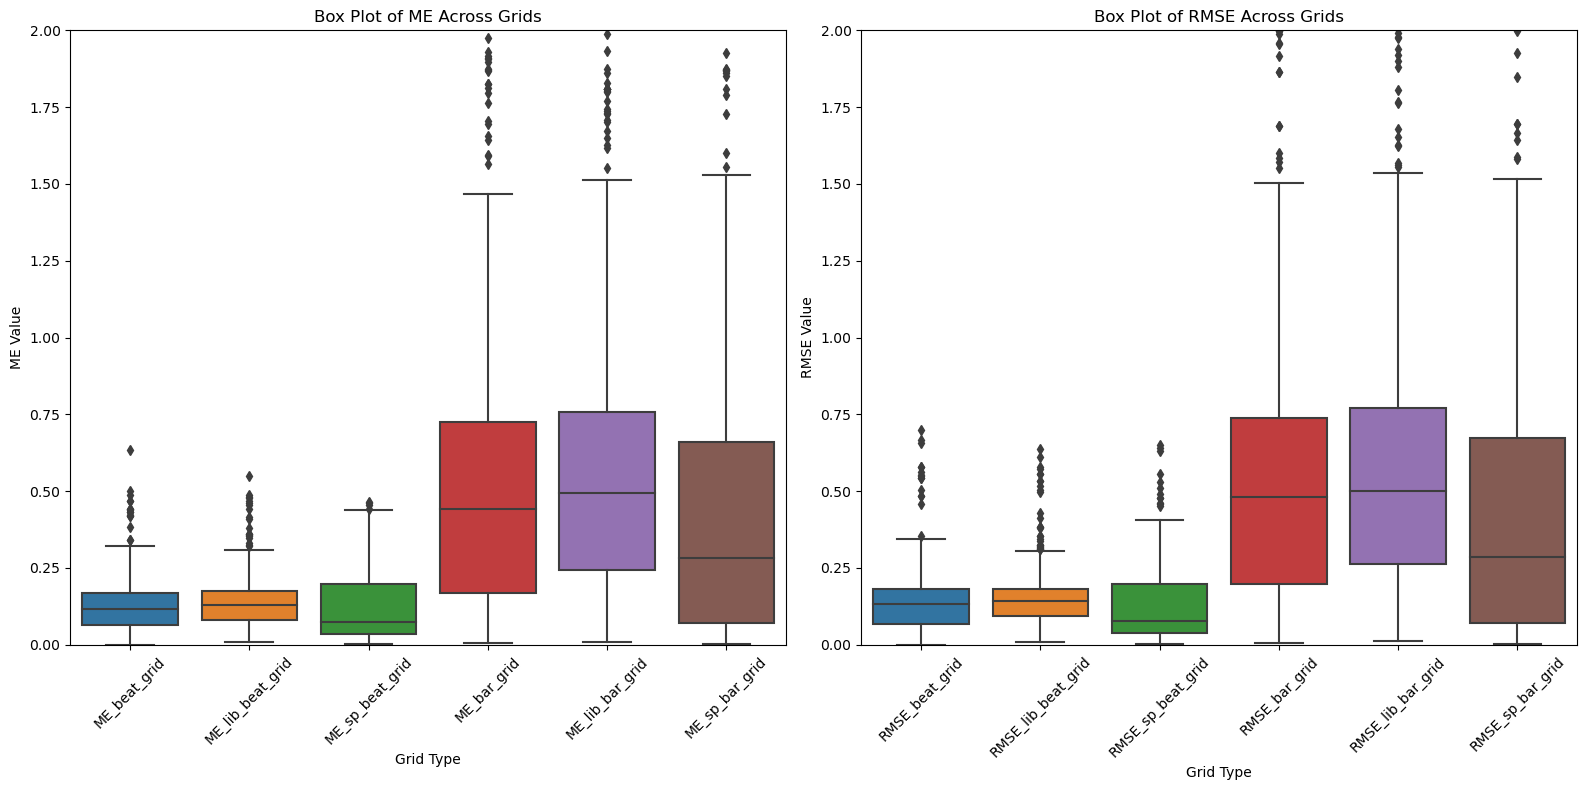

In [504]:
plt.figure(figsize=(16, 8))  # Adjust the overall figure size as needed

# Subplot 1 for ME
plt.subplot(1, 2, 1)  # Adjusted to 1 row, 2 columns, first subplot
me_columns = [f"ME_{grid}" for grid in grid_types]
sns.boxplot(data=df_chorus[me_columns])
plt.title('Box Plot of ME Across Grids')
plt.xticks(rotation=45)
plt.xlabel('Grid Type')
plt.ylabel('ME Value')
plt.ylim(0, 2)  # Adjust the y-axis range as needed

# Subplot 2 for RMSE
plt.subplot(1, 2, 2)  # Adjusted to 1 row, 2 columns, second subplot
rmse_columns = [f"RMSE_{grid}" for grid in grid_types]
sns.boxplot(data=df_chorus[rmse_columns])
plt.title('Box Plot of RMSE Across Grids')
plt.xticks(rotation=45)
plt.xlabel('Grid Type')
plt.ylabel('RMSE Value')
plt.ylim(0, 2)  # Adjust the y-axis range as needed

plt.tight_layout()
plt.show()

---

### Comparing ME of Beat times vs Bar times
#### Beat times is expected to have a lower ME than Bar times because Bar times is a subset of Beat times. 

In [505]:
# Create a simplified DataFrame for demonstration
data_beats_vs_bars = {
    'ME': np.concatenate([df_chorus['ME_beat_grid'].dropna(), df_chorus['ME_bar_grid'].dropna()]),
    'Type': ['Beat'] * len(df_chorus['ME_beat_grid'].dropna()) + ['Bar'] * len(df_chorus['ME_bar_grid'].dropna())
}
df_beats_vs_bars = pd.DataFrame(data_beats_vs_bars)

# Conducting ANOVA to check if there's a significant difference between Beat and Bar MEs
f_value_beats_bars, p_value_beats_bars = stats.f_oneway(df_beats_vs_bars[df_beats_vs_bars['Type'] == 'Beat']['ME'],
                                                        df_beats_vs_bars[df_beats_vs_bars['Type'] == 'Bar']['ME'])

print(f"\nANOVA Test Results for Beats vs. Bars:\nF-Value: {f_value_beats_bars}\nP-Value: {p_value_beats_bars}")

# If significant, you could explore further or directly interpret
if p_value_beats_bars < 0.05:
    print("Significant differences observed between Beat and Bar MEs, indicating that Beat times might indeed be lower as expected.")
else:
    print("No significant differences observed between Beat and Bar MEs.")


ANOVA Test Results for Beats vs. Bars:
F-Value: 238.24464925492921
P-Value: 5.765620908094358e-50
Significant differences observed between Beat and Bar MEs, indicating that Beat times might indeed be lower as expected.


### ANOVA Comparing Mean Difference in Bar-Chorus Alignment as a Result of Tempo Estimation Method

In [516]:
from scipy import stats
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd  

# Filter to include only bar grids
bar_grid_types = [grid for grid in grid_types if "bar_grid" in grid]

# Update ME columns to include only those for bar grids
bar_me_columns = [f"ME_{grid}" for grid in bar_grid_types]

# Preparing a list of ME values for each bar grid to use in ANOVA
bar_me_values_per_grid = [df_chorus[col].dropna() for col in bar_me_columns]

# Conducting ANOVA for bar grids only
f_value, p_value = stats.f_oneway(*bar_me_values_per_grid)

print(f"ANOVA Test Results for Bar Grids:\nF-Value: {f_value}\nP-Value: {p_value}")

# Interpreting the results of ANOVA
if p_value < 0.05:
    print("There is a statistically significant difference between the means of the bar grids. Proceeding with Tukey HSD test...")
    
    # Flatten ME values and corresponding bar grid labels into arrays for Tukey HSD test
    bar_me_values = np.concatenate(bar_me_values_per_grid)
    bar_grids = np.array([grid for grid, me_column in zip(bar_grid_types, bar_me_columns) for _ in range(len(df_chorus[me_column].dropna()))])
    
    tukey_result_bar = pairwise_tukeyhsd(endog=bar_me_values, groups=bar_grids, alpha=0.05)
    print("\nTukey HSD Test Results for Bar Grids:")
    print(tukey_result_bar)

    # Print detailed interpretation for each comparison among bar grids
    print("\nDetailed Comparison Among Bar Grids:")
    for result in tukey_result_bar.summary().data[1:]:
        print(f"Comparison between {result[0]} and {result[1]}: Mean Difference = {result[2]:.3f}, p-value = {result[3]:.3f}")
        if result[6]:
            print("  - The difference is statistically significant.\n")
        else:
            print("  - The difference is not statistically significant.\n")

ANOVA Test Results for Bar Grids:
F-Value: 9.18949445831228
P-Value: 0.00010603244583750501
There is a statistically significant difference between the means of the bar grids. Proceeding with Tukey HSD test...

Tukey HSD Test Results for Bar Grids:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1       group2    meandiff p-adj   lower  upper  reject
---------------------------------------------------------------
    bar_grid lib_bar_grid    0.041 0.3465 -0.0282 0.1101  False
    bar_grid  sp_bar_grid  -0.0832 0.0135 -0.1524 -0.014   True
lib_bar_grid  sp_bar_grid  -0.1242 0.0001 -0.1934 -0.055   True
---------------------------------------------------------------

Detailed Comparison Among Bar Grids:
Comparison between bar_grid and lib_bar_grid: Mean Difference = 0.041, p-value = 0.346
  - The difference is not statistically significant.

Comparison between bar_grid and sp_bar_grid: Mean Difference = -0.083, p-value = 0.013
  - The difference is statistically s

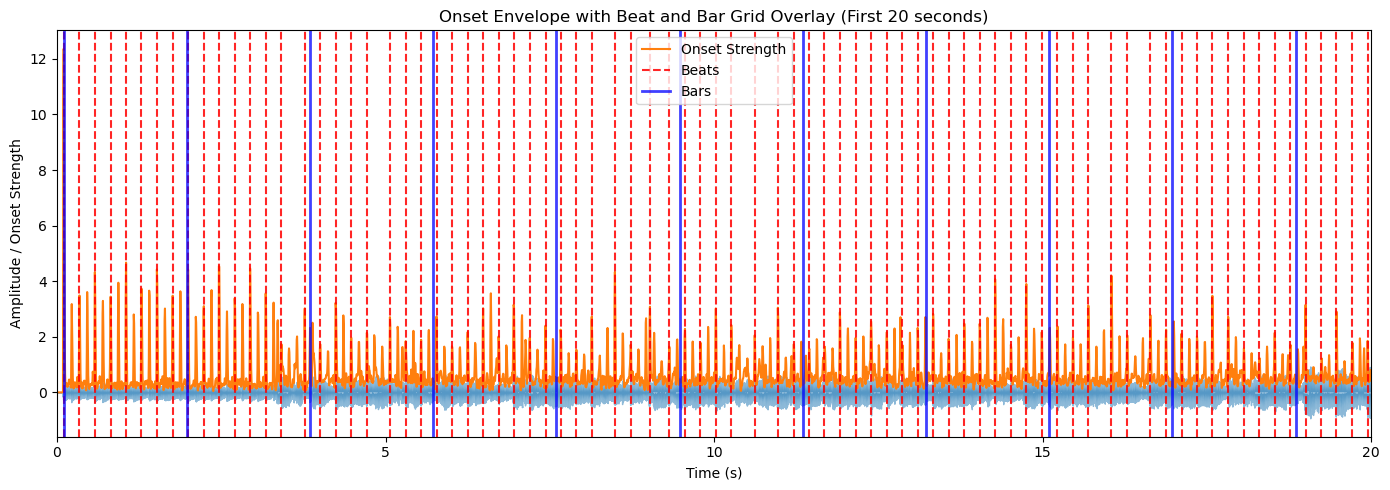

In [305]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y[:20*sr], sr=sr, alpha=0.5, max_points=3*sr)
plt.plot(librosa.times_like(onset_env[:int(20*sr/hop_length)], sr=sr, hop_length=hop_length), onset_env[:int(20*sr/hop_length)], label='Onset Strength')

# Overlay the beat grid
for beat in beat_times:
    if beat <= 20:
        plt.axvline(beat, color='r', linestyle='--', alpha=0.85, label='Beats' if beat == beat_times[0] else "")

# Overlay the bars grid
for bar in bar_times:
    if bar <= 20:
        plt.axvline(bar, color='b', linestyle='-', linewidth=2, alpha=0.75, label='Bars' if bar == bar_times[0] else "")

# Label the axes and add a legend
plt.xlabel('Time (s)')
plt.ylabel('Amplitude / Onset Strength')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Set the x limit to zoom into the first 20 seconds
plt.xlim(0, 20)

# Set the title
plt.title('Onset Envelope with Beat and Bar Grid Overlay (First 20 seconds)')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
import random

random.seed(42)
random_song_id = int(random.choice(list(df['SongID'].unique())))
audio_path = f'../data/audio_files/processed/{random_song_id}.mp3'
y, sr = librosa.load(audio_path, sr=None)
hop_length = 512
onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
tempo, beats, librosa_tempo = beat_tracking_dp(y, sr=sr, onset_env=onset_env)
time_signature = df['sp_time_signature'].values[0] if not pd.isna(df['sp_time_signature'].values[0]) else 4
time_signature = int(time_signature) if time_signature != 0 else 4
beat_times = librosa.frames_to_time(beats, sr=sr, hop_length=hop_length)
duration = librosa.get_duration(y=y, sr=sr, hop_length=hop_length)
bar_times = create_measure_grid(beat_times, tempo, time_signature, duration)
max_adjustment = (60 / (3 * tempo))
optimized_bars = optimize_measure_grid(bar_times, beats, tempo, duration)
bar_times, optimized_bars

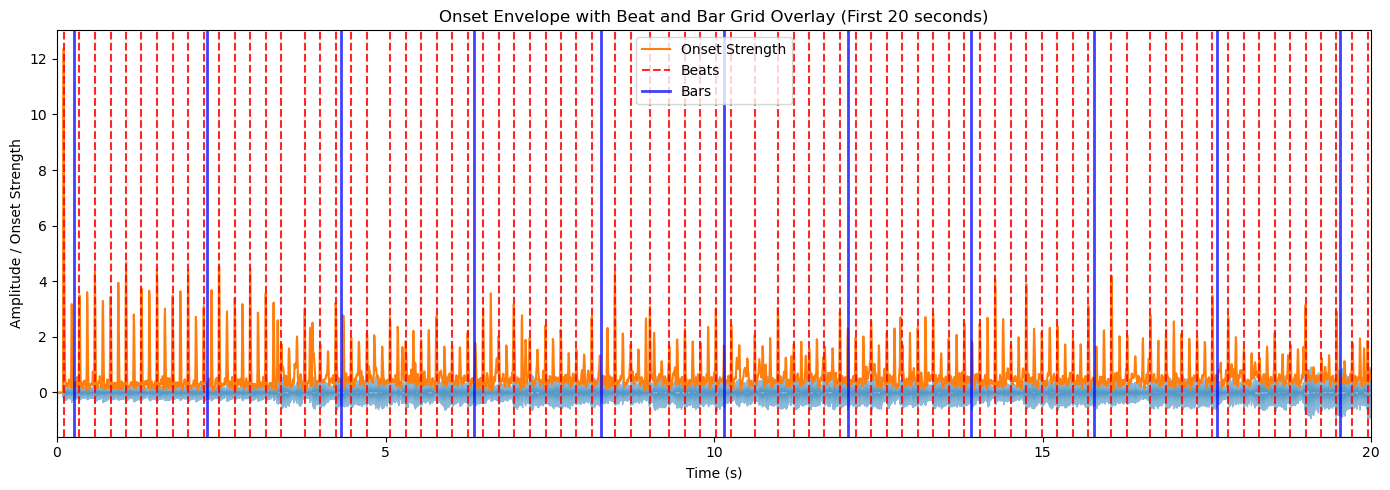

In [318]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y[:20*sr], sr=sr, alpha=0.5, max_points=3*sr)
plt.plot(librosa.times_like(onset_env[:int(20*sr/hop_length)], sr=sr, hop_length=hop_length), onset_env[:int(20*sr/hop_length)], label='Onset Strength')

# Overlay the beat grid
for beat in beat_times:
    if beat <= 20:
        plt.axvline(beat, color='r', linestyle='--', alpha=0.85, label='Beats' if beat == beat_times[0] else "")

# Overlay the bars grid
for bar in optimized_bars:
    if bar <= 20:
        plt.axvline(bar, color='b', linestyle='-', linewidth=2, alpha=0.75, label='Bars' if bar == optimized_bars[0] else "")

# Label the axes and add a legend
plt.xlabel('Time (s)')
plt.ylabel('Amplitude / Onset Strength')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Set the x limit to zoom into the first 20 seconds
plt.xlim(0, 20)

# Set the title
plt.title('Onset Envelope with Beat and Bar Grid Overlay (First 20 seconds)')

# Show the plot
plt.tight_layout()
plt.show()

In [296]:
y, sr = librosa.load(audio_path, sr=None)
hop_length = 512
onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
tempo, beats, librosa_tempo = beat_tracking_dp(y, sr=sr, onset_env=onset_env)

# Convert beat frames to time
beat_times = librosa.frames_to_time(beats, sr=sr, hop_length=hop_length)
estimated_beat_times = estimate_invisible_downbeats(beat_times, tempo)
differences = np.abs(beat_times - estimated_beat_times)
differences

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

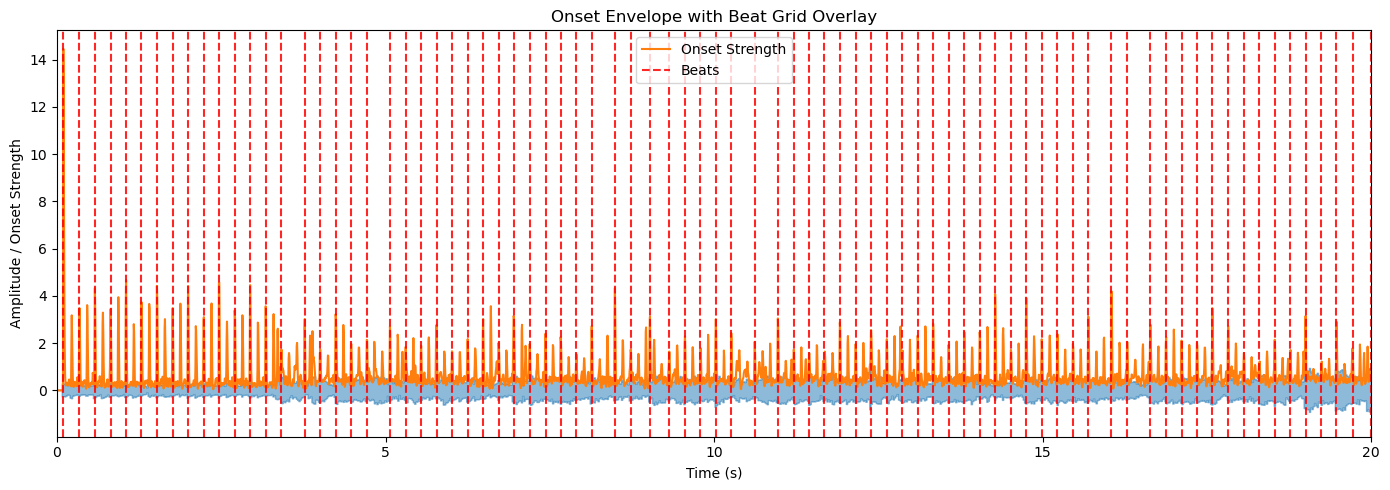

In [277]:


# Plotting the onset envelope
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.plot(librosa.times_like(onset_env, sr=sr, hop_length=hop_length), onset_env, label='Onset Strength')

# Overlay the beat grid
for beat in beat_times:
    plt.axvline(beat, color='r', linestyle='--', alpha=0.85, label='Beats' if beat == beat_times[0] else "")

# Label the axes and add a legend
plt.xlabel('Time (s)')
plt.ylabel('Amplitude / Onset Strength')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlim(0, 20)
# Set the title
plt.title('Onset Envelope with Beat Grid Overlay')

# Show the plot
plt.tight_layout()
plt.show()

### Feature Engineering 


### Exploratory Analysis

---

### Insights and Findings

In [279]:
librosa_beat_times = librosa.frames_to_time(beats, sr=sr, hop_length=hop_length)
estimated_beat_times = estimate_invisible_downbeats(librosa_beat_times, tempo)
differences = np.abs(librosa_beat_times - estimated_beat_times)
differences

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

<style>
@import url('https://fonts.googleapis.com/css2?family=Lato:ital,wght@0,100;0,300;0,400;0,700;0,900;1,100;1,300;1,400;1,700;1,900&family=Merriweather:ital,wght@0,300;0,400;0,700;0,900;1,300;1,400;1,700;1,900&display=swap');

/* Apply the Lato font to body text */
body {
    font-family: 'Lato', sans-serif;
    font-size: 12px; /* Base font size for body text */
}

/* Heading styles with Merriweather */
h1 {
    font-family: 'Merriweather', serif;
    font-size: 36px;
    font-weight: 900; /* Merriweather's boldest weight for main headings */
}

h2 {
    font-family: 'Merriweather', serif;
    font-size: 24px;
    font-weight: 700; /* Bold weight for section headings */
}

h3 {
    font-family: 'Merriweather', serif;
    font-size: 14px;
    font-weight: 700; /* Bold weight for sub-section headings */
}

h4 {
    font-family: 'Merriweather', serif;
    font-size: 12px;
    font-weight: 700; /* Bold weight for sub-sub-section headings */
}
/* Additional styles can be added for h5, h6, or other elements as needed */
</style>